In [7]:
!pip install seaborn
!pip install shutil
!pip install tensorflow
!pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
     -- ------------------------------------- 0.5/8.3 MB 9.4 MB/s eta 0:00:01
     ------- -------------------------------- 1.6/8.3 MB 14.3 MB/s eta 0:00:01
     ----------- ---------------------------- 2.4/8.3 MB 15.6 MB/s eta 0:00:01
     ----------------- ---------------------- 3.6/8.3 MB 16.3 MB/s eta 0:00:01
     --------------------- ------------------ 4.4/8.3 MB 16.5 MB/s eta 0:00:01
     ------------------------- -------------- 5.3/8.3 MB 17.1 MB/s eta 0:00:01
     ----------------------------- ---------- 6.1/8.3 MB 17.1 MB/s eta 0:00:01
     --------------------------------- ------ 7.0/8.3 MB 17.3 MB/s eta 0:00:01
     -------------------------------------- - 8.0/8.3 MB 17.7 MB/s eta 0:00:01
     ---------------------------------------  8.3/8.3 MB 17.6 MB/s eta 0:00:01
     ---------------------------------------  8.3/8.3 MB 17.6 MB/s eta 0:00:01
     ---------------------------------------  8.3/8.3 MB 17.6

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\333ya\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~klearn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Generate data paths with labels
data_path = 'Multi-class Weather Dataset'
image_paths = []
labels = []

folds = os.listdir(data_path)
for fold in folds:
    foldpath = os.path.join(data_path, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        image_paths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(image_paths, name= 'image_paths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
train_df, temp_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(temp_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [4]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'image_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'image_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'image_paths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 112 validated image filenames belonging to 4 classes.
Found 113 validated image filenames belonging to 4 classes.


In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_train_begin(self, logs= None):
        print('Do you want model asks you to halt the training [y/n] ?')
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0
        print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration'))
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        print(f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)')
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1
        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count = self.count + 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc
        print(f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}')
        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    print('enter H to halt training or an integer for number of epochs to run')
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        print(f'training has been halted at epoch {epoch + 1} due to user input')
                        self.model.stop_training = True
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            print(f' training will continue until epoch {str(self.ask_epoch)}')
                            print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'))
                        except Exception:
                            print('Invalid')

In [6]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4,383,655
Trainable params: 4,339,072
Non-trainable params: 44,583
_________________________________________

In [7]:
batch_size = 16
epochs = 60
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))
callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [8]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks, validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /60     7.858   77.556   7.45225  88.393   0.00100  0.00100  accuracy     0.00    336.35 
 2 /60     6.598   93.111   6.23674  96.429   0.00100  0.00100  val_loss    16.31    289.69 
 3 /60     5.810   96.667   5.46111  99.107   0.00100  0.00100  val_loss    12.44    303.81 
 4 /60     5.134   97.222   4.85350  98.214   0.00100  0.00100  val_loss    11.13    296.19 
 5 /60     4.575   97.667   4.36301  98.214   0.00100  0.00100  val_loss    10.11    293.56 
enter H to halt training or an integer for number of epochs to run
H
training has been halted at epoch 5 due to user input
training elapsed time was 2.0 hours, 39.0 minutes, 28.86 seconds)


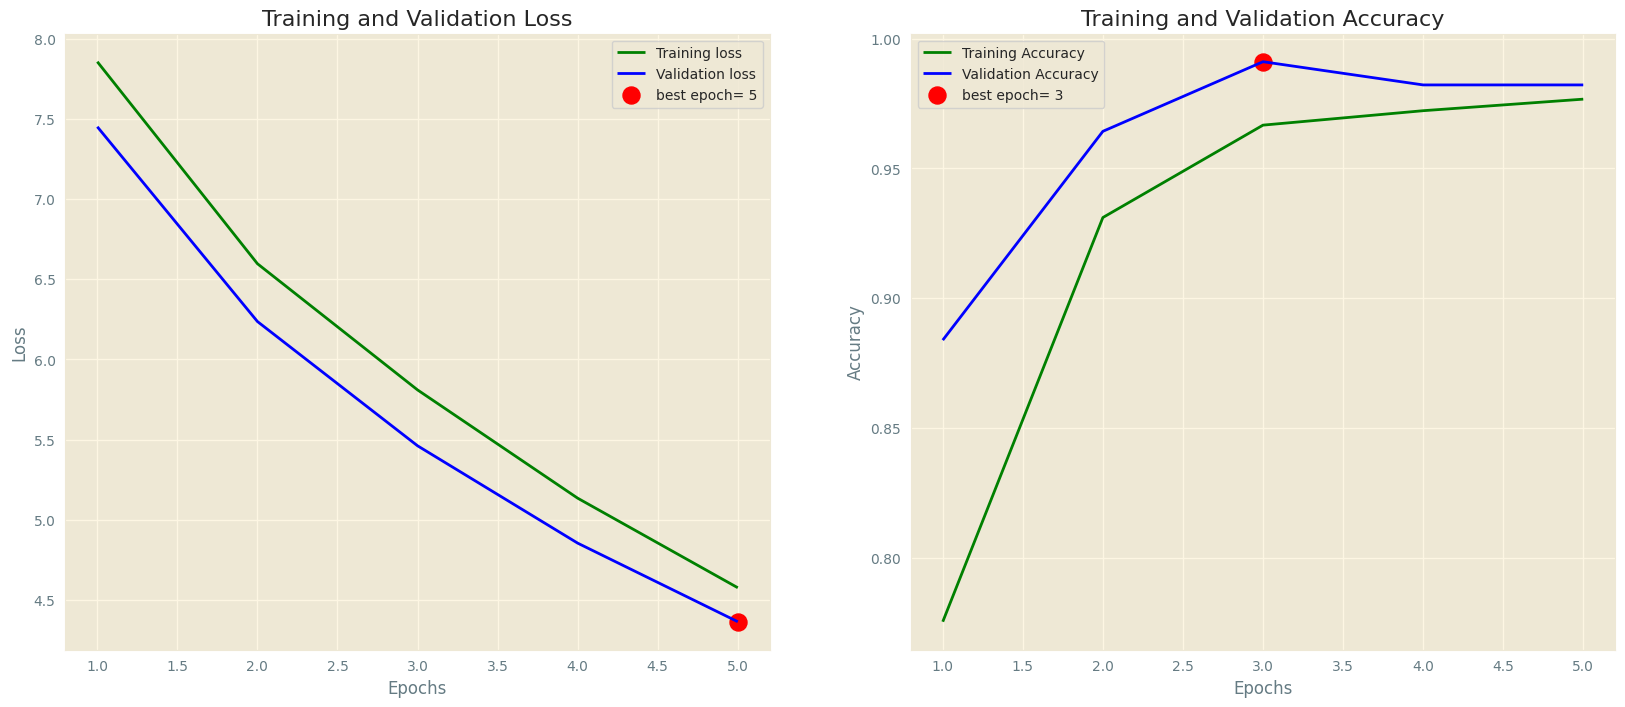

In [9]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('Solarize_Light2')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'g', label= 'Training loss')
plt.plot(Epochs, val_loss, 'b', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'g', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'b', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [10]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 57/113 [==============>...............] - ETA: 1:17 - loss: 4.3522 - accuracy: 0.9989

  7/113 [>.............................] - ETA: 2:21 - loss: 4.3630 - accuracy: 0.9821

113/113 [==============================] - 29s 256ms/step - loss: 4.4117 - accuracy: 0.9646
Train Loss:  4.3522467613220215
Train Accuracy:  0.9988889098167419
--------------------
Validation Loss:  4.36301326751709
Validation Accuracy:  0.9821428656578064
--------------------
Test Loss:  4.411717891693115
Test Accuracy:  0.9646017551422119


In [11]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

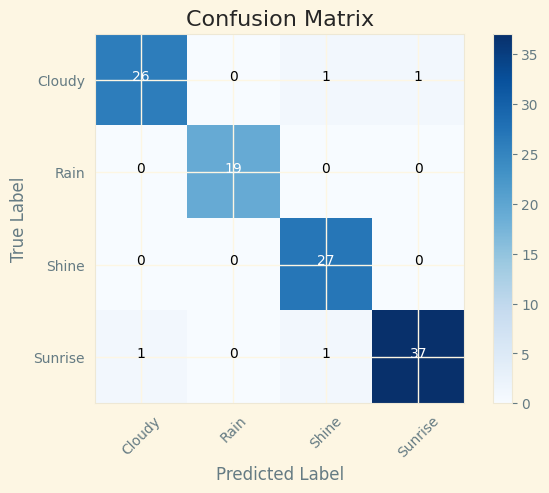

In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [13]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Cloudy       0.96      0.93      0.95        28
        Rain       1.00      1.00      1.00        19
       Shine       0.93      1.00      0.96        27
     Sunrise       0.97      0.95      0.96        39

    accuracy                           0.96       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.96      0.96       113

